# Language Classification

## Summary

XXX UPDATE FROM README!.

The model that achieves near-perfect (99.9%+) test set accuracy. While fitting the model to the whole data takes a significant amount of computation time (~2 hours), the same model fitted to a 1% subsample of the training data also achieves very good results (XXXX).

The table below lists the model results based on sample size. 


| Dataset           | Model              | Accuracy           | Training Time      | Inference Time     | Vocabulary size    | Link              |
| ------------------ | ------------------ | ------------------ | ------------------ | ------------------ | ------------------ | ------------------ |
| Full Dataset  | Word Level      | 99.97%             | 136 min      |           | 403619         | [here]() |
| 10% Sample    | Word Level      | XXXX               | XXX min      |           | XXX            | [here]() |
| 1% Sample     | Word Level      | XXXX               | XXX min      |           | XXX            | [here]() |
| 1% Sample     | Character Level | XXXX               | XXX min      |           | XXX            | [here]() |

Training time involves all preprocessing and model fitting (but not download time). Inference time involves predicting the ~20k sentences of the test set. The runs are done on a google cloud virtual machine with P100 GPU (the notebook contains full specification).

## Modelling Challanges

On the face of it, the project seems like a simple sequence classification task. Unless the test set contains text whose languages is ambiguous (the same text could pass as, say both Czech and Slovak) or contains extremely rare words, we would expect a good classifier to achieve near-perfect accuracy.

While near-perfect accuracy is indeed possible, there are two possible challenges that need to be overcome.

First, we can't rely on language specific information (after all, that's what we are trying to predict). This makes many standard NLP preprocessing steps unavailable. For example, we can't assign {'go', 'goes', 'going'} to the same word token. Even lower-casing is debatable, as some languages (for example German) capitalize words differently, a pattern that can be exploited to predict a language (German capitalizes all nouns).

Second, I chose not to use any pretrained models, or transfer learning. The challenge description wasn't clear if doing so is allowed or not; to err on the safe side, I only rely on the supplied training set. Normally, pretrained models and transfer learning is a great resource -- after all, the Internet has practically unlimited text data one can pretrain a model on.

## Character or Word Level?

Should we build a model based on sequences of characters, or sequences of words? 

If our test set were to contain many words not appearing in the training set, a character-level model would be appropriate. After all, a word-level model can't generalize outside the words it has seen. However, our training corpus is ~5 GB large, so we would expect it to contain the vast majority of common words in each language. 

Performance side, a character level model benefits from lower memory usage, but higher run-time. (The embedding space is orders of magnitude smaller, but we have to take many more steps for prediction).

I will focus on word-level modeling, but also provide a [short notebook]() on how a character-level model could be implemented (it will achieve somewhat lower accuracy). The steps for both models are almost the same.

## Loading Dependencies

I put some uninteresting function definitions into the utils.py file. The text should make it clear what each function accomplishes.

In [1]:
import sys
from pathlib import Path
import time

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import dill  # Better version of pickle, able to save objects with lambda expressions
import copy  # Used for making a deep copy of a model
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import utils

In [2]:
%matplotlib inline
start = time.time()
np.random.seed(1)

## Settings

I will discuss the reasoning behind hyper-parameter choices in the sections they become relevant. 

One important note: the notebook is written for GPU computations and will not work on a machine with CPU only (fitting the model on a cpu would take way too long anyway).

In [3]:
PATH = Path('data')  # Directory for all data and temporary files
TRAIN = PATH/'train_sampl_1pct'  # Directory for training text
TEST_FN = PATH/'test'  # Filename for test text
PATH_TMP = PATH/'tmp'  # Temporary directory to save progress

WORD_LEVEL = True  # If false, we apply character-level modelling
MIN_FREQ = 3  # We'll replace words with lower frequency with unknown

SEQ_LEN = 32 if WORD_LEVEL else 256  # Length of the sequences passed into our GRU
VAL_FRAC = 0.05  # Validation set percentage

# For the batch-size, select the largest power of 2 your GPU can comfortably handle.
# However, the optimal learning rate (see model training section) will probably change.
BS = 512  # Batch size for our RNN

EMB_SZ = 50  # Dimension of word embeddings
HIDDEN_SZ = 250  # Hidden layer dimension of the GRU
EMB_DROP = 0.25  # Dropout applied to embeddings
LAYER_DROP = 0.25  # Dropout applied after GRU
LR = 3e-3 if WORD_LEVEL else 1e-2  # Learning rate for fitting
EPOCHS = 1 if WORD_LEVEL else 2  # Epochs to train 
EPOCHS_FT = 3 if WORD_LEVEL else 3  # Epochs to fine-tune with very small learning rate (LR / 100)

# List of languages
LANGS = list(map(lambda x: x.name, list(TRAIN.iterdir())))

assert torch.cuda.is_available()  # Notebook is written for GPU computations.

In [4]:
PATH_TMP.mkdir(parents=True, exist_ok=True)

## Clarify Goal

Let's first have a look at the test set we are trying to predict. It looks like a simple text classification task.

In [5]:
test = pd.read_csv(TEST_FN, sep = '\t', lineterminator='\n', header=None)
test.rename({0:'label', 1:'text'}, axis = 1, inplace=True)
test[test['label'] == 'en'].head()

,label,text
4992,en,"(BG) Thank you, Mr President."
4993,en,"(EL) Madam President, I agree and recognise Tu..."
4994,en,"(FI) Madam President, firstly, I would like to..."
4995,en,"(FI) Mr President, the Treaty of Lisbon will r..."
4996,en,"(FR) Madam President, one of the priorities of..."


Before going any further, let's apply some preprocessing. In particular, I apply the following steps:
1. Remove uninformative meta-comments, such as who is speaking.
1. Replace numbers with a generic (*num*) token. After all, the specific number shouldn't affect the classification results.
1. Create special end-of-sentence (*eos*) tokens.
1. Replace all punctuation with a special (*punc*) token. 
1. Collapse adjecent white space. In other words, '&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;' becomes '&nbsp;'.

In [6]:
tt_start = time.time()  # We keep track of the total time needed for preprocessing+prediction
test['text'] = test['text'].apply(lambda x: utils.preprocess(x, word_level = WORD_LEVEL))
test_time = time.time()-tt_start

Let's check the first English and German sentences after pre-processing.

In [7]:
print(test[test['label']=='en'].iloc[0]["text"])
print('---')
print(test[test['label']=='de'].iloc[0]["text"])

<punct> BG <punct> Thank you <punct> Mr President <eos>
---
<punct> BG <punct> Herr Kommissar <eos> Das Dokument <punct> das vom Europäischen Parlament angenommen werden soll <punct> ist in der Tat sehr wichtig <eos>


In [8]:
def word_count(x): return len(x.split())
def sentence_count(x): return len(x.split('<eos>')) - 1
test['text'].apply([sentence_count, word_count, len]).describe()

,sentence_count,word_count,len
count,20828.000000,20828.000000,20828.000000
mean,1.113837,26.071922,175.205541
std,0.851456,25.298060,167.062078
min,1.000000,3.000000,22.000000
25%,1.000000,15.000000,99.000000
50%,1.000000,23.000000,154.000000
75%,1.000000,33.000000,224.000000
max,77.000000,2184.000000,14069.000000


The target for our classification model has the following characteristics:
1. The vast majority of examples are single sentences.
1. Most of the time, we have a decent number of words (15-33) to predict a language.
1. However, we can have as little as 3 words. This might pose a challenge if those words are not language-specific.
1. Content-wise, most sentences seem to be about parliamentary proceedings (my guess: proceedings of the EUP for more recent years).

## Preprocess Training/Validation Data

Our training set is of similar content, but in a different format. Specifically, we don't have sentence-level chunks as in our test set. Instead, we have files containing varying number of sentences. So we need to create a dataframe that resembles our test set.

First, we take all files for a language and concatenate them together.

In [9]:
# An example with English, we'll do all processing steps for all files below.
exampl = utils.concat_docs('en', TRAIN)
exampl[:200]

'<CHAPTER ID="012">\nApproval of the minutes of the previous sitting: see Minutes\n<CHAPTER ID="011">\nClimate and energy package and maritime transport package (signature of acts) \n<SPEAKER ID="333" NAME'

Now we apply the same pre-processing as we did to our test set, and turn the whole corpus into a list of sentences.

In [10]:
# Example continued.
exampl = utils.txt2list(utils.preprocess(exampl[:1000], word_level=WORD_LEVEL))
exampl[:3]

['Approval of the minutes of the previous sitting <punct> see Minutes <eos>',
 'Climate and energy package and maritime transport package <punct> signature of acts <punct> <eos>',
 'Mr Deputy Prime Minister and representative of the Presidency of the European Union <punct> Mr Nečas <punct> Commissioner Rehn <punct> honourable rapporteurs and committee chairmen <punct> ladies and gentlemen <eos>']

There is one last step we do. The test set had occasionally (although not often) multiple sentences. So we want to have, occasionally, multiple sentences in our training set as well. We can accomplish this by concatenating adjecent sentences together with a small probability (p = 0.02).

Let's apply all the above steps to all languages. I will also put everything into a dataframe with an extra column giving the language label.

In [11]:
dfs = []  # List to store data frames
for lang in LANGS:
    print(' '+lang+' ', end = "")
    txt = utils.concat_docs(lang, TRAIN)                # 1. Concatenate all files
    txt = utils.preprocess(txt, word_level=WORD_LEVEL)  # 2. Apply preprocessing described in test section
    txt = utils.txt2list(txt)                           # 3. Convert to list
    txt = utils.concat_random_sent(txt, p = 0.02)       # 4. Concatenate random adjecent sentences
    temp_df = pd.DataFrame({'text':txt})                # 5. Convert to dataframe
    temp_df['label'] = lang                             # 6. Add label   
    dfs.append(temp_df)
df = pd.concat(dfs)[['label', 'text']]
df.reset_index(inplace=True, drop = True)
df.head()

 fi  et  it  lt  pt  lv  nl  pl  bg  en  sk  fr  da  hu  cs  sl  es  el  ro  de  sv 

,label,text
0,fi,Suulliset kysymykset ja kirjalliset kannanotot...
1,fi,Ihmisoikeudet sekä sosiaali <punct> ja ympäris...
2,fi,<punct> DE <punct> Esityslistalla on seuraavan...
3,fi,Tokia Saïfin kansainvälisen kaupan valiokunnan...
4,fi,Yannick Jadotin kansainvälisen kaupan valiokun...


In [12]:
df['text'].apply([sentence_count, word_count, len]).describe()

,sentence_count,word_count,len
count,302311.000000,302311.000000,302311.000000
mean,1.020181,25.260649,166.526759
std,0.142094,16.869335,111.484502
min,1.000000,2.000000,9.000000
25%,1.000000,13.000000,88.000000
50%,1.000000,22.000000,146.000000
75%,1.000000,33.000000,219.000000
max,4.000000,694.000000,4954.000000


Our resulting dataframe looks very similar to our test set. 

One difference: we don't go quite as high on the maximum words and sentences. That difference is not going to matter though, as later on all texts will be truncated at 32 words anyway.

In [13]:
del(dfs, temp_df, txt, exampl)

In [14]:
#dill.dump(df, open(PATH_TMP/'df.pickle', mode = 'wb'))
#df = dill.load(open(PATH_TMP/'df.pickle', mode = 'rb'))

## Train/Validation Split

Let's split the data for training and validation. No big surprises here.

I use 1% of the data as validation. If that seems unusual, note that our dataset contains ~30 million, rows, so our validation set will contain ~300k. I'm only using the validation set to monitor performance and check for over-fitting. 300k examples are enough for that.

In [15]:
len(df.index)

302311

In [16]:
X_train, X_val, y_train, y_val = train_test_split(np.array(df['text']), np.array(df['label']), 
                                                  test_size=VAL_FRAC, random_state=42)
y_train

array(['en', 'en', 'sv', ..., 'en', 'fr', 'en'], dtype=object)

In [17]:
del(df)

## Numericalize

We need to turn our words into intiger indices. Later we use these indices to look up the embeddings for each word.

Let's start by counting the number of times a word appears in our training data.

In [18]:
words = Counter()
if WORD_LEVEL:
    for row in tqdm(X_train, position=0, leave=False): words.update(row.split())
else:  
    for row in tqdm(X_train, position=0, leave=False): words.update(list(row)) 
words.most_common(10)

[('<punct>', 579739),
 ('<eos>', 292986),
 ('de', 130288),
 ('a', 68799),
 ('<num>', 62024),
 ('the', 55817),
 ('en', 47998),
 ('la', 47829),
 ('in', 41979),
 ('que', 39747)]

No big surprises: the most frequent words are punctuation, end-of-sentence tokens, articles and prepositions.

Now we drop all words with frequency less than 50 (what is specified under MIN_FREQ). Doing so makes our embedding matrix smaller. Decreasing MIN_FREQ will increase the accuracy of our model, at a higher memory and computation cost.

We also add two special tokens: unknown (*unk*) and padding (*pad*). Unknown is any word not appearing in our list. These are any new words in our test or validation set, as well as the words we previously dropped due to low frequency. Padding will later be used to make all sequences of equal length. 

In [19]:
words = {k:v for k, v in tqdm(words.items(), leave = False) if v >= MIN_FREQ}
words = sorted(words, key=words.get, reverse=True)
words = ['<unk>','<pad>'] + words

In [20]:
vocab_size = len(words)
vocab_size

151746

We have more than 400k unique words. That's a lot for a regular NLP task, but considering there are 21 languages, it's not that surprising. The vocabulary size can be controlled by how many words we drop (MIN_FREQ).

We need to create a mapping from words to integers (and back). I'll use the dictionaries below to do so. Note that unknown is mapped to 0, and padding is mapped to 1 (they are the first two elements by construction).

In [21]:
word2idx = defaultdict(lambda: 0, {o:i for i,o in enumerate(words)})
idx2word = defaultdict(lambda: '<unk>', {i:o for i,o in enumerate(words)})

Here is the first sentence of the training set converted into indices:

In [22]:
if WORD_LEVEL:
    print([word2idx[w] for w in X_train[0].split()])
else:  
    print([word2idx[w] for w in list(X_train[0])])  # For character-level models

[59, 329, 4728, 7, 153, 18, 7, 1614, 159, 99, 21396, 495, 353, 1090, 3]


Now we apply the above mapping to the whole training set. I also truncate long sentences to 32 words -- that should be more than enough to classify a language, and having more words would needlessly slow down computation time.

Sentences shorter than 32 words are padded with the special (*pad*) character. This way, all example are of equal length, making subsequent computations easier.

In [23]:
X_train = utils.numericalize(X_train, word2idx, maxlen = SEQ_LEN, word_level = WORD_LEVEL)
X_val = utils.numericalize(X_val, word2idx, maxlen = SEQ_LEN, word_level = WORD_LEVEL)
print(X_train.shape)

(287195, 32)


Of course, we can alway convert our indices back. Below is our first training example converted back to text.

In [24]:
utils.de_numericalize(X_train[:1], idx2word, word_level = WORD_LEVEL)

['I am sure the Commission and the House will have noted what you said <eos>']

We'll also replace languages with contiguous integers.

In [25]:
lang2idx = defaultdict(lambda: 0, {o:i for i,o in enumerate(LANGS)})
idx2lang = defaultdict(lambda: '<unk>', {i:o for i,o in enumerate(LANGS)})

In [26]:
print(y_train[:10])  # Before
y_train = np.array([lang2idx[x] for x in y_train])
y_val = np.array([lang2idx[x] for x in y_val])
print(y_train[:10])  # After

['en' 'en' 'sv' 'en' 'nl' 'fi' 'fi' 'el' 'da' 'da']
[ 9  9 20  9  6  0  0 17 12 12]


In [27]:
#with open(PATH_TMP/'numericalized.pickle', mode = 'wb') as f:
#    dill.dump([words, vocab_size, word2idx, idx2word, X_train, X_val, y_train, y_val], f)
#with open(PATH_TMP/'numericalized.pickle', mode = 'rb') as f:
#    (words, vocab_size, word2idx, idx2word, X_train, X_val, y_train, y_val) = dill.load(f)

In [28]:
end = time.time()
print(f'Time after pre-processing : {(end - start)/60} mins')

Time after pre-processing : 0.3245467225710551 mins


## Define Dataloaders

We take our training and validation data, convert them from numpy arrays to torch tensors, and put them in dataloaders. 

In [29]:
X_train = torch.from_numpy(X_train).type(torch.int64)
y_train = torch.from_numpy(y_train).type(torch.int64)
X_val = torch.from_numpy(X_val).type(torch.int64)
y_val = torch.from_numpy(y_val).type(torch.int64)

train_dl = DataLoader(TensorDataset(X_train, y_train), batch_size=BS, shuffle = True)
valid_dl = DataLoader(TensorDataset(X_val, y_val), batch_size=BS, shuffle = False)

## Define Model

Our model is a relatively simple recurrent network. We go through our sentence word by word, look it up in our embedding matrix, and feed it into our GRU. We apply a linear layer to the final output of our GRU, which gives our predictions. 

![Model Illustration](model_illustration.jpg)

I also added dropout for regularization. I applied it at two points: first after our embedding lookup, and then before the final linear layer.

Why not use something more complicated (say, a bidirectional LSTM)? It's simply not needed. The task is relatively simple, no need for an overkill.

### On Hyperparameters

The model is quite insensitive to changes in hyper-parameters. My experiments indicated that changing most modeling parameters by a factor of 0.2 - 5 doesn't change the validation accuracy much.

The most surprising hyper-parameter is probably the embedding size. Usual NLP tasks have embedding dimensions of 200-700. However, our model doesn't need to learn a rich semantic representation for each word, only what is relevant to language prediction. Moreover, given our large vocabulary size we can easily run into memory errors if we choose too high of an embedding dimension. An embedding size of 50 suffices.

I chose to use moderate amount dropout and a somewhat larger hidden layer than necessary. This choice just follows conventional deep learning advice: a regularized larger model usually performs better than an un-regularized smaller one.

In [30]:
# The code below is a straightforward pytorch implementation of the concepts above
class Lang_Detect(nn.Module):
    def __init__(self, emb_sz = EMB_SZ, vocab_size = vocab_size,
                 hidden_sz = HIDDEN_SZ, out_sz = len(LANGS), 
                 emb_drop = EMB_DROP, layer_drop = LAYER_DROP):
        super().__init__()
        self.hidden_sz = hidden_sz
        self.emb = nn.Embedding(vocab_size, emb_sz)
        self.emb_drop = nn.Dropout(emb_drop)
        self.emb.weight.data.uniform_(-0.05, 0.05)  # Initialize embeddings
        self.gru = nn.GRU(emb_sz, hidden_sz)
        self.layer_drop = nn.Dropout(layer_drop)
        self.lout = nn.Linear(hidden_sz, out_sz)        
                
    def forward(self, seq): 
        bs, _ = seq.shape
        h =  torch.zeros(1, bs, self.hidden_sz).cuda()  # Initial empty hidden state
        embedded = self.emb(seq).transpose(0, 1)
        outputs, _ = self.gru(self.emb_drop(embedded), h)
        output = self.lout(self.layer_drop(outputs[-1]))
        return output

In [31]:
model = Lang_Detect().cuda()

I use standard cross-entropy as the loss function.

In [32]:
loss_func = nn.CrossEntropyLoss().cuda()

## Fit Model

I create a special class that helps with fitting the model. It is model agnostic, and can help fit other pytorch models as well.

First a helper function that calculates the loss for a batch, and updates parameters:

In [33]:
def loss_batch(xb, yb, model, loss_func, opt=None):
    
    '''Calculates the loss for a minibatch, and (if opt is given) updates parameters'''
    # Taken from: https://github.com/fastai/fastai_v1/blob/master/dev_nb/001a_nn_basics.ipynb

    loss = loss_func(model(xb.cuda()), yb.cuda())
    if opt is not None:  # Update parameters
        loss.backward(); opt.step(); opt.zero_grad()
        
    return loss.item(), len(xb)

The Learner class below has 3 methods to help the fitting process:
- **lr_find**: to find the optimal learning rate,
- **fit**: to fit the model,
- **predict**: to predict on new data,
- **plot_loss**: plot the training loss.

The inspiration for this class is the [fast.ai](https://github.com/Gokkulnath/fastai-v0.7) library (version 0.7, now depreciated), which contains similar classes for fitting pytorch models.

I use the Adam optimizer with default settings.

In [34]:
class Learner(object):
    
    def __init__(self, model, loss_func, train_dl = None, valid_dl = None):
        self.model = model
        self.loss_func = loss_func
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.losses = []
    
    def lr_find(self, start = 1e-6, end = 1e3, exp_smooth_param = 0.95):
        
        '''Learning rate finder, detailed explanation below.'''
        
        old_state_dict = copy.deepcopy(self.model.state_dict())  # Save old parameters
        self.model.train()
        lr = start; lrs = []; losses = []; i = 0
        for xb,yb in tqdm(self.train_dl, leave = False,
                         position = 0):
            opt = optim.Adam(self.model.parameters(), lr=lr)
            loss, _ = loss_batch(xb, yb, self.model, self.loss_func, opt)
            lrs.append(lr), losses.append(loss)
            if (lr > end) or (i > 10 and loss > 3*np.mean(losses[:i])):
                break  # Stop if losses shoot up higher than the average loss so far
            lr *= 1.03; i += 1        
        self.losses = losses  # Previous losses aren't relevant for plotting
        self.plot_loss(x = lrs, xlog=True, exp_smooth_param = exp_smooth_param)
        self.losses = []  # Reset list
        # Note: we don't want to keep the parameters, as at the end of the algorithm
        # very high learning rates are used, and the loss is high. Hence, we
        # reset it
        self.model.load_state_dict(old_state_dict)
        
    def plot_loss(self, x = None, xlog = False, exp_smooth_param = 0.95):
        '''Plots training loss. Each datapoint is a mini-batch.'''
        # Note: plots losses from all epochs (since the last lr_find call)
        
        # Use exponental smoothing with parameter exp_smooth_param
        y_smooth = utils.exp_smooth(np.array(self.losses), exp_smooth_param)
        f, ax = plt.subplots(figsize=(5, 5))
        if xlog:  # Use log on both scales
            ax.set(yscale = 'log', xscale = 'log')  
        else: 
            ax.set(yscale = 'log')
        if x is not None:
            ax = plt.plot(x, y_smooth)
        else:
            ax = plt.plot(y_smooth)     
            
    def fit(self, lr, epochs):
        
        '''Fits model for specified number of epochs, with learning rate lr.'''
        
        opt = optim.Adam(self.model.parameters(), lr=lr)
        
        for epoch in range(epochs):
        
            # Fit model to training data
            self.model.train()  # Enables dropout
            losses, nums = zip(*[loss_batch(xb, yb, self.model, self.loss_func, opt) 
                                 for xb,yb in tqdm(self.train_dl, leave = False, position = 0)])
            train_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
            self.losses = self.losses+list(losses)
            
            # Apply model to validation data
            if self.valid_dl != None:             
                self.model.eval()  # Disables dropout
                with torch.no_grad():  # No gradient calculations
                    
                    # Note: loss_batch doesn't update parameters if not supplied with
                    # an optimizer. So this loop only calculates the loss.
                    losses,nums = zip(*[loss_batch(xb, yb, self.model, self.loss_func)
                                        for xb,yb in valid_dl])
                    val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
                    
                    # Also compute validation accuracy
                    val_preds = self.predict(self.valid_dl)
                    y_val = self.valid_dl.dataset.tensors[1]
                    acc = utils.accuracy(val_preds, y_val) 
                    # Note: in this case, refactoring code means we run the model through
                    # the validation set twice. That's okay - the validation set is small.
                    
                print(f'Epoch {epoch}. Training loss: {train_loss}. ' +
                      f'Validation loss: {val_loss}. Accuracy: {acc}')  
            else:  
                print(f'Epoch {epoch}. Training loss: {train_loss}.')
                        
    def predict(self, dl):
        '''Gives predictions on supplied dataloader, concatenates results.'''
        self.model.eval()  # No dropout
        with torch.no_grad():  # No gradient calculations
            res = [self.model(xb.cuda()).argmax(dim = -1).view(-1) for 
                   xb, _ in tqdm(dl, leave = False, position = 0)]
        return torch.cat(res)

In [35]:
learn = Learner(model, loss_func, train_dl, valid_dl)

Let's use our untrained model to predict the validation set. As expected, it's about as good as chance.

In [36]:
preds = learn.predict(valid_dl)
utils.accuracy(preds, y_val)

0.022426567875099234

In order to fit our model, we have to give it a learning rate. A learning rate that's too high will not converge on a minimum, a learning rate that's too low will take too long to find one.

The lr_find method helps us pick a good learning rate: neither too high, nor too low. Originally, the idea was mentioned in [this](https://arxiv.org/abs/1506.01186) paper, a nice blog post explaining the concept is [here](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html).

We start fitting our neural net with a very low learning rate (1e-6). Then after each minibatch, we increase it a little (by 3%). We do it until we reach a rate that's too high (1e3), or until our loss sharply increases.

What tends to happen: at low learning rates, our loss doesn't improve. At a certain point, it decreases steeply. However, moving past this optimal range, or loss shoots up as we are taking update steps too big.

Here is our (smoothed) loss plotted against the learning rate. Note that we don't want to pick the minimum: at that point the learning rate is already too high. Instead we want to pick a point where we are improving at a steady-but-safe rate.

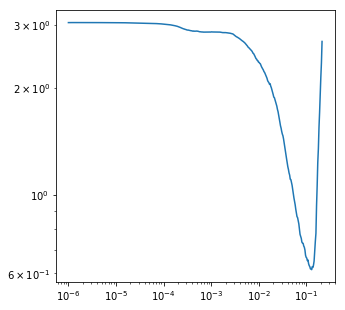

In [37]:
learn.lr_find()

To err on the safe side, I choose a relatively low rate. Training this network is relatively fast anyway.

Epoch 0. Training loss: 0.5088759451657577. Validation loss: 0.06306600106964354. Accuracy: 0.9832627679280233


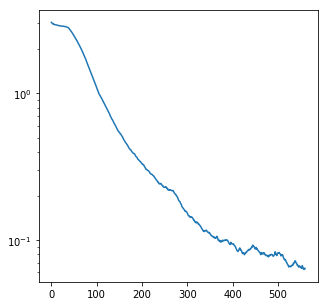

In [38]:
learn.fit(LR, EPOCHS)
#dill.dump(learn.model.state_dict(), open(PATH_TMP/'model0.pickle', mode = 'wb'))
learn.plot_loss()

We are already achieving good validation accuracy. Our loss seems to stagnate after ~40k mini-batches, so training at this learning rate any more is pointless. Instead, let's decrease our learning rate by two orders of magnitude and fit just a little more to fine-tune our model.

  1%|          | 5/561 [00:00<00:12, 46.26it/s]

Epoch 0. Training loss: 0.04218713187264849. Validation loss: 0.05228526349770673. Accuracy: 0.9865705213019317


  0%|          | 1/561 [00:00<01:13,  7.67it/s]

Epoch 1. Training loss: 0.039410674104207254. Validation loss: 0.05103246226106317. Accuracy: 0.9863720560994972


Epoch 2. Training loss: 0.03813133705310421. Validation loss: 0.049695484760136285. Accuracy: 0.9867689865043663


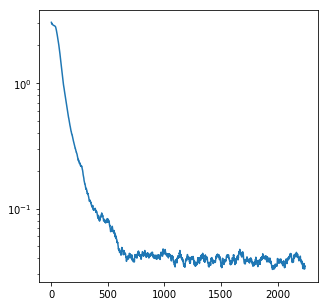

In [39]:
learn.fit(LR/1e2, EPOCHS_FT)
#dill.dump(learn.model.state_dict(), open(PATH_TMP/'model1.pickle', mode = 'wb'))
learn.plot_loss()

Even though it's not noticeable on the plot, our loss is actually still decreasing. We could train it a bit further, maybe even experiment with lower learning rates for further fine-tuning. However, our model is pretty good at this point - and early stopping helps with generalizability anyway.

In [40]:
end = time.time()
print(f'Time after training : {(end - start)/60} mins')

Time after training : 1.2215304215749105 mins


## Predict Test Set

We start with mapping our test text to integers as well.

In [41]:
tt_start = time.time()
X_test = utils.numericalize(np.array(test['text']), word2idx, maxlen = SEQ_LEN, word_level = WORD_LEVEL)
y_test = np.array([lang2idx[x] for x in test['label']])

We then convert our arrays to torch tensors and put them into a data-loader.

In [42]:
X_test = torch.from_numpy(X_test).type(torch.int64)
y_test = torch.from_numpy(y_test).type(torch.int64)

test_dl = DataLoader(TensorDataset(X_test, y_test), batch_size=BS, shuffle = False)

In [43]:
preds = learn.predict(test_dl)
test_time = test_time + time.time() - tt_start
print(f'Total time for prediction : {(test_time)} secs')
print(f'Test set accuracy: {utils.accuracy(preds, y_test)}')

Total time for prediction : 1.1741220951080322 secs
Test set accuracy: 0.98794891492222


Our test set accuracy is great. Let's have a look at accuracy by language.

In [44]:
test['pred'] = [idx2lang[x] for x in utils.conv2np(preds)]
test['correct'] = (test['pred'] == test['label'])*1
inc_total = len(test.index)-sum(test['correct'])
print(f"Total number of mispredicted: {inc_total} out of {len(test.index)}")
test.groupby(by = 'label')['correct'].agg('mean').sort_values()

Total number of mispredicted: 251 out of 20828


label
sk    0.966631
cs    0.969000
pl    0.971000
ro    0.973060
lt    0.975000
sl    0.977000
hu    0.983000
lv    0.983657
et    0.984000
es    0.991000
bg    0.993000
da    0.996000
fi    0.997000
en    0.997000
de    0.997000
el    0.997984
pt    0.998000
sv    0.998000
it    0.999000
nl    0.999000
fr    0.999000
Name: correct, dtype: float64

For almost all languages we achieve 100% accuracy. It's also not surprising that Czech and Slovak have the worst accuracy. 

Let's have a look at the examples we mis-predicted.

In [45]:
def print_incorrect(n):
    
    '''Prints n incorrectly classified sentences.'''
    
    misclas = test[test['correct']==0]
    ex = misclas.sample(min(n, len(misclas.index)), replace = False)
    
    for idx in ex.index:
        print(f'class: {test.iloc[idx]["label"]}, ', end = "")
        print(f'predicted: {test.iloc[idx]["pred"]}, ', end = "")
        temp = utils.de_numericalize(X_test.numpy()[idx:(idx+1)], idx2word, word_level = WORD_LEVEL)
        print(f'text: {temp}, ', end = "")
        print('\n')   

In [46]:
print_incorrect(10)

class: ro, predicted: it, text: ['Să <unk> piaţa europeană de <unk> <eos>'], 

class: hu, predicted: cs, text: ['<unk> eredményeként mindkét <unk> <unk> <unk> fogják <eos>'], 

class: fr, predicted: fi, text: ['<unk> requise <punct> <num> <eos>'], 

class: sl, predicted: pl, text: ['Za začetek je <unk> organov odločanja finančnih <unk> očitno <unk> <eos>'], 

class: sk, predicted: sl, text: ['To predtým nebolo možné <eos>'], 

class: cs, predicted: hu, text: ['<unk> a <unk> <eos>'], 

class: sk, predicted: cs, text: ['<unk> poskytovanie <unk> informácií a pomôže <unk> <unk> si <unk> <unk> výrobky <eos>'], 

class: sl, predicted: sk, text: ['Rezultat so <unk> le <num> <punct> <unk> volivcev <eos>'], 

class: sk, predicted: sl, text: ['Turecku chcem <unk> tri odkazy <eos>'], 

class: pl, predicted: lt, text: ['Dlaczego <unk> <unk> to robić <eos>'], 



There are only 8 wrong predictions.
1. One of the six is a data error (the 'danish' text is assigned the wrong label).
1. Five are short sentences with low-frequency words.

In [47]:
end = time.time()
print(f'Total time : {(end - start)/60} mins')

Total time : 1.2296830495198567 mins


## Run-Time

The whole model takes ~2 hours to train. Training was done on google cloud, with the following machine specifications:

- 1 P100 GPU
- 30 GB Ram
- 8 CPU cores

As a pre-embtible instance, such a machine costs ~$0.5 / hour (as of 2018 November). 

## Try with own example text

In [48]:
# These examples are in English, German and Hungarian respectively
own_examples = ["Let's see if this sentence gets classified correctly.", 
 'Das können wir auch ausprobieren',
 'Ezt a szöveget is megpróbáljuk lefordítani.']

In [49]:
def predict_own(ex_list, learn_obj = learn, langmapper = idx2lang, 
                seq_len = SEQ_LEN,
                word2idx = word2idx, word_level = WORD_LEVEL):
    '''Predict the language of a a custom list of example sentences. Whole pipeline.'''
    y = torch.zeros(len(ex_list))                                     # 1. Dummy y for data loader
    f = lambda x: utils.preprocess(x, word_level)
    exampl = np.array(list(map(f, ex_list)))                          # 2. Preprocess, convert to numpy
    idxs = utils.numericalize(exampl, word2idx, seq_len, word_level)  # 3. Numericalize
    idxs = torch.from_numpy(idxs).type(torch.int64)                   # 4. Convert to torch tensor
    dl = DataLoader(TensorDataset(idxs, y), batch_size=BS, shuffle = False)  # 6. Put in dataloader
    res = learn_obj.predict(dl)                                       # 7. Predict language index
    res = [langmapper[x] for x in utils.conv2np(res)]                 # 8. Map index to language
    return res

In [50]:
predict_own(own_examples)

['en', 'de', 'hu']